In [1]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample

(1) 46 states & 109 counties (NA did not count)
(2) Missing values in each column:
       freq
0      103
1675    22
1177     1
1174     1
1        1
(3) Missing values in each column:
    freq
0   103


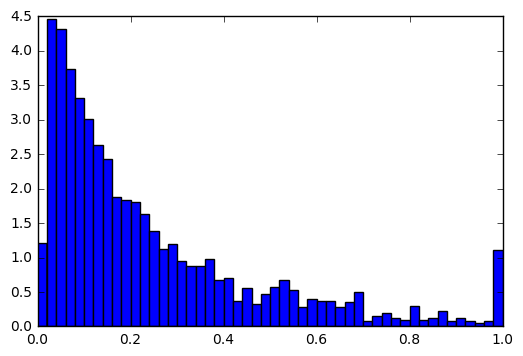

In [2]:
df = pd.read_csv('communities.csv')
n_row, n_col = df.shape
states, counties = Series.unique(df['state']), Series.unique(df['county'])
print('(1) {:d} states & {:d} counties (NA did not count)'.format(len(states), len(counties)))

miss_stat = df.isnull().sum()  # Series
print('(2) Missing values in each column:\n', miss_stat.value_counts().to_frame(name='freq'))

clean_cols = [col for col, f in miss_stat.iteritems() if f == 0]
df = df.loc[:, clean_cols]  # Discard all columns with more than 50% of the values missing
miss_stat = df.isnull().sum()  # Series
print('(3) Missing values in each column:\n', miss_stat.value_counts().to_frame(name='freq'))

response_name = 'ViolentCrimesPerPop'
plt.hist(df[response_name], bins=50, normed=True)
plt.show()

In [3]:
# Part-II
predictors = list(df.columns)
predictors.remove('communityname')
predictors.remove(response_name)
X, y = df.loc[:, predictors], df[response_name]  # X <= 1994 * 101
n_row, n_col = X.shape
selector = SelectKBest(score_func=f_regression, k=1)
selector.fit(X, y)
predictors = [pname for pname, _ in sorted(zip(predictors, selector.scores_), key=lambda x: x[1], reverse=True)] 

# def forward_stepwise():  # X & y & predictors implicitly passed
#     estimator = LinearRegression()
#     remaining = set(X.columns)
#     # remaining.remove(response_name)
#     selected = []
#     best_formula = []
#     cur_score, best_new_score = 0.0, 0.0
#     while remaining and cur_score == best_new_score:
#         scores_candidates = []
#         for candidate in remaining:
#             formula = selected + [candidate]
#             score = estimator.fit(X.loc[:, formula], y).score(X.loc[:, formula], y)
#             scores_candidates.append((score, candidate))
#         scores_candidates.sort()
#         best_new_score, best_candidate = scores_candidates.pop()
#         if cur_score < best_new_score:
#             remaining.remove(best_candidate)
#             selected.append(best_candidate)
#             cur_score = best_new_score
#             best_formula = [_ for _ in selected]
#     return best_formula


def forward_stepwise():  # X & y & predictors implicitly passed
    estimator = LinearRegression()
    best_k, smallest_mae = 0, 1 
    for k in range(1, n_col+1):
        mae = - cross_val_score(estimator, X.loc[:, predictors[:k]], y, scoring='neg_mean_absolute_error').mean()
        if mae < smallest_mae:
            best_k, smallest_mae = k, mae
    return predictors[:best_k]


def backward_stepwise():  # X & y & predictors implicitly passed
    estimator = LinearRegression()
    best_k, smallest_mae = 0, 1 
    for k in range(n_col, 0, -1):
        mae = - cross_val_score(estimator, X.loc[:, predictors[:k]], y, scoring='neg_mean_absolute_error').mean()
        if mae < smallest_mae:
            best_k, smallest_mae = k, mae
    return predictors[:best_k]

# best_preds = backward_stepwise()  # 100 predictors
# best_preds = backward_stepwise()
# print(len(best_preds))


# As Python does not have corresponding module for bi-directional stepwise model selection,
# here I actually made use of sklearn.model_selection.SelectKBest 
def bidirectional_stepwise():
    estimator = LinearRegression()
    best_k, smallest_mae = 0, 1
    for k in range(n_col, 0, -1):
        X_new = SelectKBest(k=k).fit_transform(X, y)
        mae = - cross_val_score(estimator, X_new, y, scoring='neg_mean_absolute_error').mean()
        if mae < smallest_mae:
            best_k, smallest_mae = k, mae
    return predictors[:best_k]


def stepwise_model_select(funcs):  # with report functionality
    estimator = LinearRegression()
    mxfunc, mxscore, mxselect = None, 0, None
    for func in funcs:
        selected = func()
        r2_score = cross_val_score(estimator, X.loc[:, selected], y, scoring='r2').mean()
        print('Method {}: model-size {}, r2-score {}'.format(func.__name__, len(selected), r2_score))
        if r2_score > mxscore:
            mxfunc, mxscore, mxselect = func, r2_score, selected
    print('\n{} achieves highest r2 score: {}\n'.format(mxfunc.__name__, mxscore))
    return mxselect

In [4]:
# Part-III

# (1) Choosing optimal model & reasoning
features = stepwise_model_select((forward_stepwise, backward_stepwise, bidirectional_stepwise))
print('Finally picked features:\n', Series(features))

'''
From the significant predictors we can find that 
the greater percentage of a complete famliy is usually a boost to greater society environment,
and percentage of various race also have an impact on crime rates.   
'''

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


Method forward_stepwise: model-size 37, r2-score 0.6364151740937912


Method backward_stepwise: model-size 37, r2-score 0.6364151740937912


Method bidirectional_stepwise: model-size 35, r2-score 0.6327519563100504

forward_stepwise achieves highest r2 score: 0.6364151740937912
Finally picked features:
 0             PctKids2Par
1                PctIlleg
2              PctFam2Par
3            racePctWhite
4        PctYoungKids2Par
5             PctTeen2Par
6            racepctblack
7              pctWInvInc
8             pctWPubAsst
9            FemalePctDiv
10            TotalPctDiv
11        PctPersOwnOccup
12         MalePctDivorce
13         PctPopUnderPov
14          PctUnemployed
15         PctHousNoPhone
16           PctNotHSGrad
17       PctVacantBoarded
18         PctHousLess3BR
19               NumIlleg
20          PctHousOwnOcc
21       PctPersDenseHous
22            NumUnderPov
23              medFamInc
24              medIncome
25             HousVacant
26        PctLess9thGrade
27        PctLargHouseFam
28          NumInShelters
29             population
30         PctWOFullPlumb
31              numbUrban
32  

'\nFrom the significant predictors we can find that \nthe greater percentage of a complete famliy is usually a boost to greater society environment,\nand percentage of various race also have an impact on crime rates.   \n'

In [5]:
# Part-III

# (2) 10-fold cv
estimator = LinearRegression()
sum_mse = 0.0
for fold in range(1, 11):
    test_rows = X['fold'] == fold
    train_rows = X['fold'] != fold
    X_train, X_test = X.loc[train_rows, features], X.loc[test_rows, features]
    y_true = y[test_rows]
    y_pred = estimator.fit(X_train, y[train_rows]).predict(X_test)
    sum_mse += mean_squared_error(y_true, y_pred)
print('Estimated Test MSE: {:f}'.format(sum_mse / 10.0))

Estimated Test MSE: 0.018972


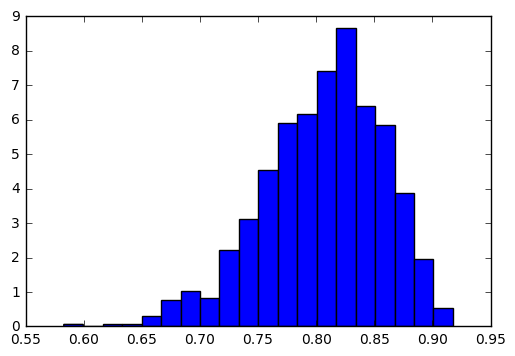

90% Confidential Interval: (0.7168288187074033, 0.8842050174183975)


In [6]:
# (3) Bootstrap sampling & get confidential interval
scores = []
for i in range(1000):
    X_sub, y_sub = resample(X.loc[:, features], y, n_samples=100)
    score = r2_score(y_sub, LinearRegression().fit(X_sub, y_sub).predict(X_sub))
    scores.append(score)
heights, bins, _ = plt.hist(scores, bins=20, normed=True)
plt.show()


def get_conf_interval(heights, bins, ratio):
    threshold = sum(heights) * ratio
    lo = heights.argmax()
    hi = lo + 1
    cur_sum = heights[lo]
    while cur_sum < threshold:
        if lo == 0 or (hi < len(heights) and heights[lo-1] < heights[hi]):
            cur_sum += heights[hi]
            hi += 1
        else:
            cur_sum += heights[lo-1]
            lo -= 1
    return bins[lo], bins[hi]

lo, hi = get_conf_interval(heights, bins, 0.9)
print('90% Confidential Interval: ({}, {})'.format(lo, hi))